# Import

In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from torchaudio.datasets import VCTK_092

import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard.writer import SummaryWriter
from tqdm import tqdm
import os

from IPython.display import Audio
from IPython.display import display

# Cuda Manegement

In [2]:
torch.cuda.empty_cache()
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(f"Total Memory: {t}")
print(f"Reserved Memory: {r}")
print(f"Allocated Memory: {a}")
print(f"Free Memory: {f}")

Total Memory: 12779126784
Reserved Memory: 0
Allocated Memory: 0
Free Memory: 0


# Hyperparameters

In [3]:
BATCH_SIZE = 32
EPOCHS = 10
WAVE_LENGTH = 81920#40960
LEARNING_RATE = 0.001
SPLIT = 0.5

# Utility Methods

In [4]:
def nparams(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_waveform(waveform, sample_rate, limit=False):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if limit:
        axes.set_ylim(-1, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

# Dataset Class for deal with audio tracks

In [5]:
class EqualDataset(Dataset):
    def __init__(self, dataset, wave_length):
        self.data = dataset
        
        #self.idx_to_speaker = self.data._speaker_ids
        self.wave_length = wave_length

        # train_size = 1
        # val_size = len(self.data) - train_size
        # train_dataset, _ = torch.utils.data.random_split(self.data, [train_size, val_size])
        # self.data = train_dataset
            

    def __getitem__(self, index):
        waveform, sample_rate, _, speaker_id, _ = self.data[index]
        #speaker_id = self.idx_to_speaker.index(speaker_id)
        wave_length = waveform.shape[1]
        if wave_length > self.wave_length:
            waveform = self._random_cut_(waveform, wave_length)
        elif wave_length < self.wave_length:
            waveform = torch.cat([waveform, torch.zeros(1, self.wave_length - wave_length)], dim=1)
        return waveform, sample_rate, speaker_id

    def __len__(self):
        return len(self.data)
    
    def _random_cut_(self, w, wl):
        start = torch.randint(wl - self.wave_length, (1,))
        wave = w[:, start:start+self.wave_length]
        return wave
    
    def get_max_id(self):
        return len(self.idx_to_speaker)

# Trainer Class for training, saving and plotting results

In [6]:
class Trainer:
    def __init__(self, device, model, opt, path=None):
        self.device = device
        self.model = model
        self.model.to(self.device)
        self.opt = opt
        self.loss_train = []
        self.loss_test = []
        self.abs_mean_train = []
        self.abs_mean_test = []
        self.epochs = 0
        if path:
            self.model.load_state_dict(torch.load(path))
            
    def train(self, epochs, dl_train, dl_test=None, check=100, save=False):
        self.model.train()
        self.loss_train = []
        self.loss_test = []
        self.abs_mean_train = []
        self.abs_mean_test = []
        for i in range(self.epochs+1,self.epochs+epochs+1):
            avg_loss_train, abs_mean_tr = self._train_epoch_(dl_train, i)
            self.abs_mean_train.append(abs_mean_tr)
            self.loss_train.append(avg_loss_train)
            if i%check==0 and i !=0:
                print(f"Epoch {i} -> Train Loss: {avg_loss_train}")
                if save:
                    model_string = self.model.name + ".pt"
                    path = "./models/" + model_string
                    torch.save(self.model.state_dict(), path)
            if dl_test:
                avg_loss_test, abs_mean_te = self._test_epoch_(dl_test, i)
                self.loss_test.append(avg_loss_test)
                self.abs_mean_test.append(abs_mean_te)
                if i%check==0 and i !=0:
                    print(f"Epoch {i} -> Test Loss: {avg_loss_test}")

            self.epochs += 1
        self._plot_()

    def get_index_dataset(self, dl_train):
        with torch.no_grad():
            idx = torch.tensor([])
            for waveform, _, _ in tqdm(dl_train, desc=f'Getting Indexes', leave = False):
                waveform = waveform.float().to(self.device)
                min_idx = self.model.get_vq_indexes(waveform)
                idx = torch.cat([idx, min_idx.cpu()])
            return idx
    
    def _train_epoch_(self, dl_train, epoch):
        epoch_loss = 0
        for waveform, _, speaker_id in tqdm(dl_train, desc=f'Training epoch {epoch}', leave = False):
            waveform = waveform.float().to(self.device)
            logits, vq_loss = self.model(waveform)
            total_loss = F.mse_loss(logits, waveform) + vq_loss
            abs_mean = torch.mean(torch.abs(logits - waveform)).item()

            self.opt.zero_grad()
            total_loss.backward()
            self.opt.step()
            epoch_loss += total_loss.item()
        return epoch_loss / len(dl_train), abs_mean
    
    def _test_epoch_(self, dl_test, epoch):
        epoch_loss = 0
        with torch.no_grad():
            for waveform, _, speaker_id in tqdm(dl_test, desc=f'Testing epoch {epoch}', leave = False):
                waveform = waveform.float().to(self.device)
                logits, vq_loss = self.model(waveform)
                total_loss = F.mse_loss(logits, waveform) + vq_loss
                epoch_loss += total_loss.item()
                abs_mean = torch.mean(torch.abs(logits - waveform)).item()
            return epoch_loss / len(dl_test), abs_mean

    def _plot_(self):
        fig, (axs) = plt.subplots(2,1)

        axs[0].plot(self.loss_train, label="Train", color="red")
        #axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("Loss")

        axs[1].plot(self.abs_mean_train, label="Train", color="red")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Mean Absolute Error")

        if self.loss_test:
            axs[0].plot(self.loss_test, label="Test", color="blue")
            axs[0].legend(loc="upper right")
            axs[1].plot(self.abs_mean_test, label="Test", color="blue")
            axs[1].legend(loc="upper right")

# Data Initialization

In [7]:
vctk = VCTK_092("./datasets", download=True)
train_size = int(SPLIT * len(vctk))
val_size = len(vctk) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(vctk, [train_size, val_size])

vctk_train_eq = EqualDataset(train_dataset, WAVE_LENGTH)
vctk_train_dl = DataLoader(vctk_train_eq, batch_size=BATCH_SIZE, shuffle=True)

vctk_val_eq = EqualDataset(val_dataset, WAVE_LENGTH)
vctk_val_dl = DataLoader(vctk_val_eq, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# vctk_train = VCTK_092("./datasets", download=True)
# vctk_eq = EqualDataset(vctk_train, WAVE_LENGTH)
# vctk_train_dl = DataLoader(vctk_eq, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
for _, (waveform, sample_rate, speaker_id) in enumerate(vctk_train_dl):
    print(waveform.shape)
    print(sample_rate.shape)
    #print(speaker_id.shape)
    break

torch.Size([32, 1, 81920])
torch.Size([32])


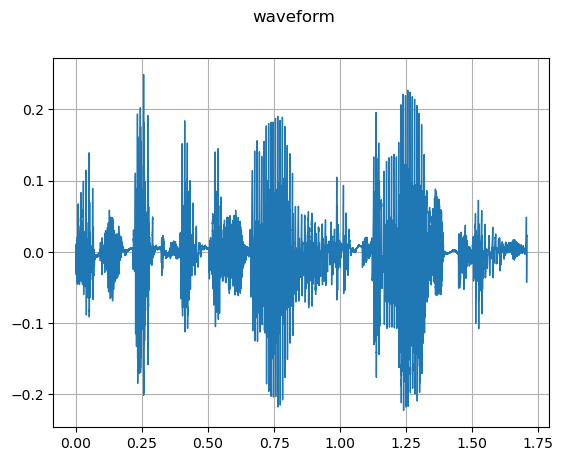

In [31]:
plot_waveform(waveform[0], sample_rate[0])

# Network Definition

In [8]:
class ResBlock(nn.Module):
    def __init__(self, channels, kernel_size):
        super().__init__()
        self.block = nn.Sequential(*[
            nn.Conv1d(channels, channels, kernel_size, padding="same", bias=False),
            nn.BatchNorm1d(channels),
            nn.Tanh(),
            nn.Conv1d(channels, channels, kernel_size, padding="same", bias=False),
            nn.BatchNorm1d(channels),
        ])

    def forward(self, x):
        out = self.block(x)
        out = out + x
        return F.tanh(out)

In [9]:
class ConvEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, res_blocks, kernel_size):
        super().__init__()
        self.in_block = nn.Sequential(*[
            nn.Conv1d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.Tanh()
        ])
        self.res_block = nn.Sequential(*[ResBlock(out_channels, kernel_size) for _ in range(res_blocks)])

    def forward(self, x):
        out = self.in_block(x)
        return self.res_block(out)
        #return out

In [10]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, emb_dim, res_blocks, kernel_size=3):
        super().__init__()
        self.blocks = nn.Sequential(*[ConvEncoderBlock(hidden_dim[i], hidden_dim[i+1], res_blocks, kernel_size) for i in range(len(hidden_dim)-1)])
        self.emb_conv = nn.Sequential(*[
            nn.Conv1d(hidden_dim[-1], emb_dim, kernel_size, padding="same", bias=False),
            nn.BatchNorm1d(emb_dim),
            nn.Tanh(),
        ])

    def forward(self, x):
        out = self.blocks(x)
        return self.emb_conv(out)

In [11]:
class VQ(nn.Module):
    #K=nemb=dimension of the discrete space (eq quantize each input, among one of K vectors)
    #D=emb_dim=dimension of the embedding space
    def __init__(self, emb_dim=64, nemb=512, beta=0.25):
        super().__init__()
        self.emb_dim = emb_dim
        self.nemb = nemb
        self.beta = beta
        self.embedding = nn.Embedding(nemb, emb_dim)
        self.embedding.weight.data.uniform_(-1/nemb, 1/nemb)

    def forward(self, x): #x has shape B, C, T
        #We want to express the data as points of embedding dimension without taking into account batch and time dimension
        B, C, T = x.shape
        z_e = x.permute(0, 2, 1)
        z_e = z_e.reshape(B*T, self.emb_dim)
        #dist has shape B*T, nemb
        dist = torch.cdist(z_e, self.embedding.weight, p=2)
        #We want to find the closest embedding vector for each point
        min_idx = torch.argmin(dist, dim=1)
        min_one_hot = F.one_hot(min_idx, num_classes=self.nemb).float()
        e = min_one_hot @ self.embedding.weight

        #restore the original shape but now with the embedded points
        e = e.view(B, T, self.emb_dim).permute(0, 2, 1)
        vq_loss = F.mse_loss(x.detach(), e) + self.beta * F.mse_loss(x, e.detach())
        return e, vq_loss, min_idx.reshape(B,-1)

In [12]:
class ConvTransposeDecoder1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)

    def forward(self, x):
        B,C,T = x.shape
        out = self.conv(x, output_size=(B,int(C/2),T*2))
        return out

In [13]:
class TransposeConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, res_blocks, kernel_size):
        super().__init__()
        self.trans_block = nn.Sequential(*[
            ConvTransposeDecoder1d(in_channels, out_channels, kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.Tanh()
        ])
        self.res_block = nn.Sequential(*[ResBlock(out_channels, kernel_size) for _ in range(res_blocks)])

    def forward(self, x):
        out = self.trans_block(x)
        return self.res_block(out)

In [14]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim, emb_dim, res_blocks, kernel_size=3):
        super().__init__()
        self.emb_conv = nn.Sequential(*[
            nn.Conv1d(emb_dim, hidden_dim[0], kernel_size, padding="same", bias=False),
            nn.BatchNorm1d(hidden_dim[0]),
            nn.Tanh()
        ])
        self.up_layers = nn.Sequential(*[TransposeConvBlock(hidden_dim[i], hidden_dim[i+1], res_blocks, kernel_size) for i in range(len(hidden_dim)-1)])

    def forward(self, x):
        out = self.emb_conv(x)
        out = self.up_layers(out)
        return out


In [15]:
class VQVAE(nn.Module):
    def __init__(self, in_channels=1, start_dim=16, nemb=512, emb_dim=1024, ndown=6, res_blocks=1, kernel_size=3, beta = 0.25):
        super().__init__()
        self.name = "VQVAE " + "nemb=" + str(nemb) + " emb_dim=" + str(emb_dim) + " ndown=" + str(ndown)
        hidden_dim = [in_channels] + [int(start_dim*(2**i)) for i in range(ndown)]

        self.encoder = Encoder(hidden_dim, emb_dim, res_blocks, kernel_size)
        self.vq = VQ(emb_dim, nemb, beta)
        hidden_dim.reverse()
        self.decoder = Decoder(hidden_dim, emb_dim, res_blocks, kernel_size)


    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss, _ = self.vq(z_e)
        #Add the connection between the input the decoder and the output of the encoder, to propagate the gradient
        z_q = z_e + (z_q - z_e).detach()
        x_hat = self.decoder(z_q)
        return x_hat, vq_loss

    def get_vq_indexes(self, x):
        z_e = self.encoder(x)
        _, _, min_idx = self.vq(z_e)
        return min_idx


# Training

In [32]:
device = get_device()
print(f"Using device: {device}")
model_vctk = VQVAE(in_channels=1, start_dim=16, nemb=512, emb_dim=256, ndown=6, res_blocks=1, kernel_size=3)
print(nparams(model_vctk))
#print(model_vctk)
opt_vctk = torch.optim.Adam(model_vctk.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE/10)
trainer_vctk = Trainer(device, model_vctk, opt_vctk)

Using device: cuda
4596140


In [38]:
trainer_vctk.train(epochs=10, dl_train=vctk_train_dl, check=1, save=True)

Epoch 11 -> Train Loss: 0.0030938482277554193


Epoch 12 -> Train Loss: 0.003090159682612649


KeyboardInterrupt: 

0.0002852682664524764


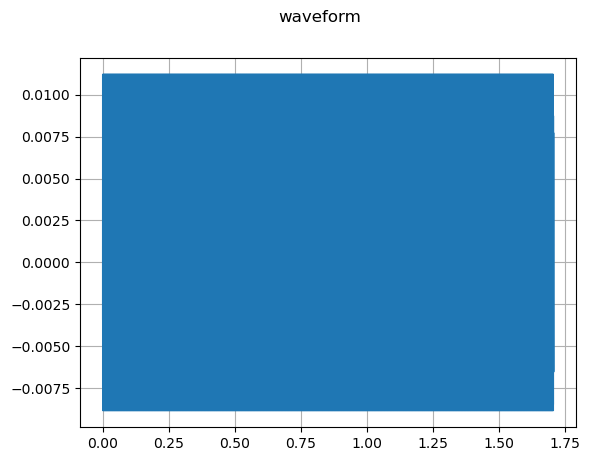

In [39]:
with torch.no_grad():
    model_vctk.eval()
    logits, vq_loss = model_vctk(waveform[1].unsqueeze(0).float().to(device))
    print(F.mse_loss(logits, waveform[1].unsqueeze(0).float().to(device)).item())
    plot_waveform(logits[0].detach().cpu(), sample_rate[0])

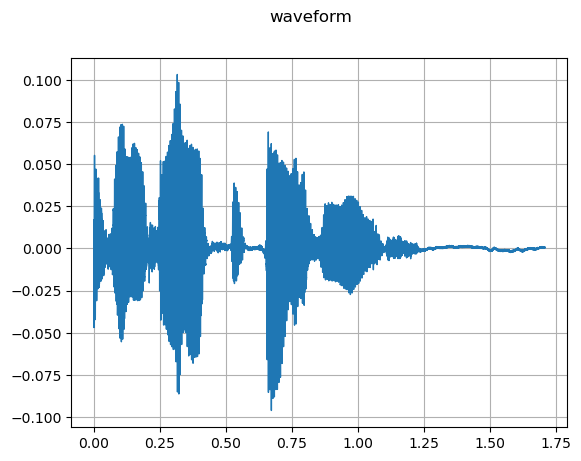

In [35]:
plot_waveform(waveform[1], sample_rate[0])

In [ ]:
audio_original = Audio(waveform[1].detach().cpu(), rate=sample_rate[0].item())
display(audio_original)

In [ ]:
audio_reconstructed = Audio(logits[0].detach().cpu(), rate=sample_rate[0].item())
display(audio_reconstructed)

# Test on Validation DataLoader

In [36]:
for _, (waveform_val, sample_rate_val, _) in enumerate(vctk_val_dl):
    print(waveform_val.shape)
    print(sample_rate_val.shape)
    #print(speaker_id.shape)
    break

torch.Size([32, 1, 81920])
torch.Size([32])


0.0009714585612528026


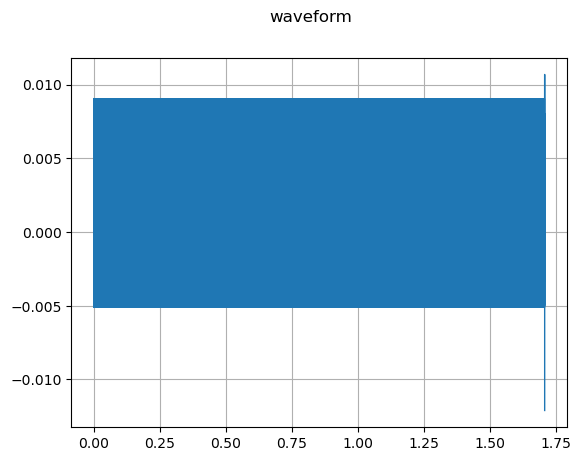

In [37]:
with torch.no_grad():
    model_vctk.eval()
    logits, vq_loss = model_vctk(waveform_val[1].unsqueeze(0).float().to(device))
    print(F.mse_loss(logits, waveform_val[1].unsqueeze(0).float().to(device)).item())
    plot_waveform(logits[0].detach().cpu(), sample_rate_val[0])

In [ ]:
plot_waveform(waveform_val[1], sample_rate[0])

In [ ]:
audio_original = Audio(waveform_val[1].detach().cpu(), rate=sample_rate[0].item())
display(audio_original)

In [ ]:
audio_reconstructed = Audio(logits[0].detach().cpu(), rate=sample_rate[0].item())
display(audio_reconstructed)

# Load Model

In [16]:
device = get_device()
print(f"Using device: {device}")
model_vctk = VQVAE(in_channels=1, start_dim=16, nemb=512, emb_dim=1024, ndown=6, res_blocks=1, kernel_size=3)
opt_vctk = torch.optim.Adam(model_vctk.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE/10)

model_string = model_vctk.name + ".pt"
path = "./models/" + model_string
trainer_vctk = Trainer(device, model_vctk, opt_vctk, path)

Using device: cuda


# Dataset of VQ Indexes

In [17]:
idx_dataset = trainer_vctk.get_index_dataset(vctk_train_dl)
print(idx_dataset.shape)    

torch.Size([21936, 1280])


In [18]:
dim = 0
perm = torch.randperm(idx_dataset.shape[dim])
idx_dataset = idx_dataset[perm]
train_size = int(0.8 * len(idx_dataset))
val_size = len(idx_dataset) - train_size
train_idx, val_idx = idx_dataset[:train_size], idx_dataset[train_size:]

In [19]:
train_dl_idx = DataLoader(TensorDataset(train_idx[:, :-1].unsqueeze(1), train_idx[:, 1:]), batch_size=BATCH_SIZE, shuffle=True)
val_dl_idx = DataLoader(TensorDataset(val_idx[:, :-1].unsqueeze(1), val_idx[:, 1:]), batch_size=BATCH_SIZE, shuffle=True)

In [20]:
for _, (idx_src,idx_tgt) in enumerate(train_dl_idx):
    print(idx_src.shape, idx_tgt.shape)
    break

torch.Size([32, 1, 1279]) torch.Size([32, 1279])


# WaveNet Architecture

In [21]:
class WaveTrainer:
    def __init__(self, device, model, opt, path=None):
        self.device = device
        self.model = model
        self.model.to(self.device)
        self.opt = opt
        self.loss_train = []
        self.loss_test = []
        self.epochs = 0
        if path:
            self.model.load_state_dict(torch.load(path))
            
    def train(self, epochs, dl_train, dl_test=None, check=100, save=False):
        self.model.train()
        self.loss_train = []
        self.loss_test = []
        for i in range(self.epochs+1,self.epochs+epochs+1):
            avg_loss_train = self._train_epoch_(dl_train, i)
            self.loss_train.append(avg_loss_train)
            if i%check==0 and i !=0:
                print(f"Epoch {i} -> Train Loss: {avg_loss_train}")
                if save:
                    model_string = self.model.name + ".pt"
                    path = "./models/" + model_string
                    torch.save(self.model.state_dict(), path)
                if dl_test:
                    avg_loss_test = self._test_epoch_(dl_test, i)
                    print(f"Epoch {i} -> Test  Loss: {avg_loss_test}")
            self.epochs += 1
        self._plot_()
    
    def _train_epoch_(self, dl_train, epoch):
        epoch_loss = 0
        for x, y in tqdm(dl_train, desc=f'Testing epoch {epoch}', leave = False):
            x = x.to(self.device)
            y = y.long().to(self.device)
            logits = self.model(x)
            total_loss = nn.CrossEntropyLoss()(logits, y)

            self.opt.zero_grad()
            total_loss.backward()
            self.opt.step()
            epoch_loss += total_loss.item()
        return epoch_loss / len(dl_train)
    
    def _test_epoch_(self, dl_test, epoch):
        with torch.no_grad():
            epoch_loss = 0
            for x, y in tqdm(dl_test, desc=f'Training epoch {epoch}', leave = False):
                x = x.to(self.device)
                y = y.long().to(self.device)
                logits = self.model(x)
                total_loss = nn.CrossEntropyLoss()(logits, y)
                epoch_loss += total_loss.item()
            return epoch_loss / len(dl_test)

    def _plot_(self):
        fig, (axs) = plt.subplots(1,1)

        axs.plot(self.loss_train, label="Train", color="red")
        axs.set_xlabel("Epochs")
        axs.set_ylabel("Loss")

In [22]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.pad = (kernel_size - 1)*dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation, padding=self.pad, bias=False)

    def forward(self, x):
        out = self.conv(x)
        out = out[:, :, :-self.pad] #we remove the extra element top of the tensor that could not be inferred
        return out

In [23]:
class GatedUnitBlock(nn.Module):
    def __init__(self, res_channels, skip_channels, kernel_size, dilation):
        super().__init__()
        self.sigma_conv = nn.Sequential(
            CausalConv1d(res_channels, res_channels, kernel_size, dilation=dilation),
            nn.Sigmoid()
        )
        self.tan_conv = nn.Sequential(
            CausalConv1d(res_channels, res_channels, kernel_size, dilation=dilation),
            nn.Tanh()
        )
        self.res_out = nn.Conv1d(res_channels, res_channels, 1)
        self.skip_conv = nn.Conv1d(res_channels, skip_channels, 1)


    def forward(self, x):
        sigma = self.sigma_conv(x)
        tan = self.tan_conv(x)
        out = sigma * tan
        res_out = self.res_out(out) + x
        skip_out = self.skip_conv(out)
        return res_out, skip_out

In [24]:
class WaveNet(nn.Module):
    def __init__(self, in_channels, res_channels, skip_channels, kernel_size, nclasses, ndilations):
        super().__init__()
        self.name = "WaveNet " + "res_channels=" + str(res_channels) + " skip_channels=" + str(skip_channels) + " ndilations=" + str(ndilations)
        self.start_conv = nn.Conv1d(in_channels, res_channels, 1)
        self.blocks = nn.ModuleList([GatedUnitBlock(res_channels, skip_channels, kernel_size, 2**i) for i in range(ndilations)])
        self.out_layers = nn.Sequential(
            nn.Conv1d(skip_channels, nclasses, 1),
            nn.ReLU(),
            nn.Conv1d(nclasses, nclasses, 1)
        )

    def forward(self, x):
        out = self.start_conv(x)
        skip_connections = 0
        for block in self.blocks:
            res_out, skip_out = block(out)
            skip_connections = skip_connections + skip_out
            out = res_out
        out = F.relu(skip_connections)
        out = self.out_layers(out)
        return out

In [25]:
wave_vctk = WaveNet(in_channels=1, res_channels=64, skip_channels=128, kernel_size=2, nclasses=512, ndilations=4)
print(nparams(wave_vctk))
print(wave_vctk)
wave_opt = torch.optim.Adam(wave_vctk.parameters(), lr=0.01, weight_decay=LEARNING_RATE/10)
trainer_wave = WaveTrainer(device, wave_vctk, wave_opt)

444288
WaveNet(
  (start_conv): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (blocks): ModuleList(
    (0): GatedUnitBlock(
      (sigma_conv): Sequential(
        (0): CausalConv1d(
          (conv): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,), bias=False)
        )
        (1): Sigmoid()
      )
      (tan_conv): Sequential(
        (0): CausalConv1d(
          (conv): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,), bias=False)
        )
        (1): Tanh()
      )
      (res_out): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (skip_conv): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    )
    (1): GatedUnitBlock(
      (sigma_conv): Sequential(
        (0): CausalConv1d(
          (conv): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        )
        (1): Sigmoid()
      )
      (tan_conv): Sequential(
        (0): CausalConv1d(
          (conv): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(2,),

In [28]:
trainer_wave.train(epochs=100, dl_train=train_dl_idx, dl_test=val_dl_idx, check=10, save=True)

Epoch 210 -> Train Loss: 1.1484922449662602


Epoch 210 -> Test  Loss: 1.0990944319013236


Epoch 220 -> Train Loss: 1.451366011996521


Epoch 220 -> Test  Loss: 1.470481999542402


Epoch 230 -> Train Loss: 1.216452183619223


Epoch 230 -> Test  Loss: 1.1819581734961357


Epoch 240 -> Train Loss: 1.0615949966217


Epoch 240 -> Test  Loss: 1.0160697236441183


Epoch 250 -> Train Loss: 1.1045838832203807


Epoch 250 -> Test  Loss: 1.0877026267673657


Epoch 260 -> Train Loss: 0.7570293123387682


Epoch 260 -> Test  Loss: 0.7578709721565247


Epoch 270 -> Train Loss: 1.0568536455948279


Epoch 270 -> Test  Loss: 1.00855384486309


Epoch 280 -> Train Loss: 1.048400186992951


Epoch 280 -> Test  Loss: 1.0394961544568988


KeyboardInterrupt: 

In [29]:
for _, (idx_src,idx_tgt) in enumerate(val_dl_idx):
    print(idx_src.shape, idx_tgt.shape)
    break
logits = wave_vctk(idx_src.to(device).float())
print(logits.shape)
probs = F.softmax(logits, dim=1)
print(probs.shape)
preds = torch.argmax(probs, dim=1)
print(preds.shape)
print(preds[0, :10])
print(idx_tgt[0, :10])
print(torch.sum(preds[0]==idx_tgt.to(device)[0]))

torch.Size([32, 1, 1279]) torch.Size([32, 1279])
torch.Size([32, 512, 1279])
torch.Size([32, 512, 1279])
torch.Size([32, 1279])
tensor([ 9,  9,  9,  9,  9, 20,  8,  8,  9,  8], device='cuda:0')
tensor([ 9., 20.,  2.,  1.,  8.,  2., 20.,  8., 10., 20.])
tensor(726, device='cuda:0')
